# NLP Project — IMDb Sentiment & News Classification (Colab)

This Colab-ready notebook contains two complete projects:

- **Part A:** IMDb Movie Review Sentiment Analysis
- **Part B:** News Article Classification

It is configured to **mount Google Drive**, read your datasets from
`/content/drive/MyDrive/NLP_Project/IMDB Dataset.csv` and
`/content/drive/MyDrive/NLP_Project/data_news.csv`, and includes
beginner-friendly explanations and runnable cells.

Run cells top → bottom. Use GPU: `Runtime > Change runtime type > GPU`.

In [1]:
!pip install --quiet numpy pandas matplotlib seaborn scikit-learn nltk tensorflow transformers gensim tqdm joblib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 91.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
import os, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# DL
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Input, Bidirectional, GlobalAveragePooling1D, Lambda
from tensorflow.keras.callbacks import EarlyStopping

# Transformers
from transformers import AutoTokenizer, TFAutoModel

# Word2Vec
from gensim.models import Word2Vec

# NLTK downloads
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('punkt_tab') # Added punkt_tab download

sns.set(style='whitegrid')
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)
print('imports done')

imports done


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [5]:
# Update: paths are pre-configured for your Drive folder
IMDB_PATH = '/content/drive/MyDrive/NLP_Project/IMDB Dataset.csv'
NEWS_PATH = '/content/drive/MyDrive/NLP_Project/data_news.csv'

# quick existence checks
print('IMDB exists:', os.path.exists(IMDB_PATH))
print('News exists:', os.path.exists(NEWS_PATH))

IMDB exists: True
News exists: True


In [6]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text, lowercase=True, remove_stopwords=True):
    if not isinstance(text, str):
        return ''
    text = text.replace('\n',' ').replace('\r',' ')
    text = re.sub(r"http\S+", '', text)
    text = re.sub(r"[^A-Za-z0-9' ]+", ' ', text)
    if lowercase:
        text = text.lower()
    tokens = nltk.word_tokenize(text)
    if remove_stopwords:
        tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return ' '.join(tokens)


def print_scores(y_true, y_pred, labels=None):
    if len(np.unique(y_true))==2:
        avg='binary'
    else:
        avg='macro'
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred, average=avg, zero_division=0)
    rec = recall_score(y_true, y_pred, average=avg, zero_division=0)
    f1 = f1_score(y_true, y_pred, average=avg, zero_division=0)
    print(f'Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}\n')
    print('Classification Report:\n', classification_report(y_true, y_pred, zero_division=0, target_names=labels))

print('helpers ready')

helpers ready


## Part A — IMDb Sentiment Analysis

Load the IMDb dataset and inspect it.

In [7]:
imdb_df = pd.read_csv(IMDB_PATH)
imdb_df.columns = [c.lower() for c in imdb_df.columns]
print('columns:', imdb_df.columns.tolist())
display(imdb_df.head())
print('shape:', imdb_df.shape)

columns: ['review', 'sentiment']


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

shape: (50000, 2)


Missing reviews: 0
Missing sentiments: 0
value counts:
sentiment
1    25000
0    25000
Name: count, dtype: int64


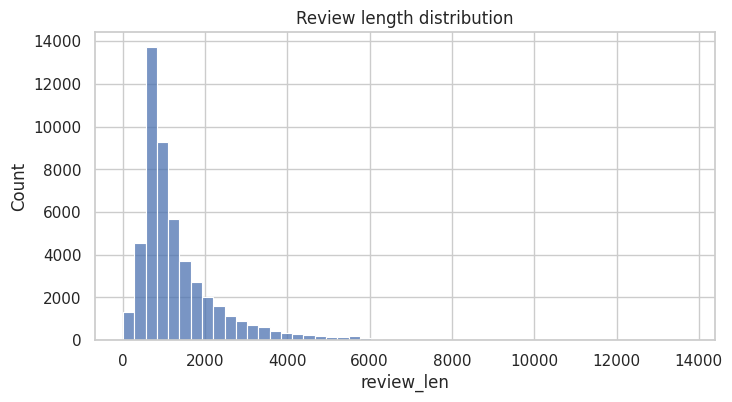

In [8]:
print('Missing reviews:', imdb_df['review'].isna().sum())
print('Missing sentiments:', imdb_df['sentiment'].isna().sum())

# normalize sentiment
if imdb_df['sentiment'].dtype == object:
    imdb_df['sentiment'] = imdb_df['sentiment'].map({'positive':1, 'negative':0, 'pos':1, 'neg':0}).fillna(imdb_df['sentiment'])

if imdb_df['sentiment'].dtype == object:
    imdb_df['sentiment'] = imdb_df['sentiment'].astype('category').cat.codes

print('value counts:')
print(imdb_df['sentiment'].value_counts())

imdb_df['review_len'] = imdb_df['review'].astype(str).apply(len)
plt.figure(figsize=(8,4))
sns.histplot(imdb_df['review_len'], bins=50)
plt.title('Review length distribution')
plt.show()

In [11]:
imdb_df['review_clean'] = imdb_df['review'].astype(str).apply(clean_text)
display(imdb_df[['review','review_clean']].head())

review  \
0  One of the other reviewers has mentioned that ...   
1  A wonderful little production. <br /><br />The...   
2  I thought this was a wonderful way to spend ti...   
3  Basically there's a family where a little boy ...   
4  Petter Mattei's "Love in the Time of Money" is...   

                                        review_clean  
0  one reviewer mentioned watching oz episode 'll...  
1  wonderful little production br br filming tech...  
2  thought wonderful way spend time hot summer we...  
3  basically 's family little boy jake think 's z...  
4  petter mattei 's love time money visually stun...

In [12]:
X = imdb_df['review_clean'].values
y = imdb_df['sentiment'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)
print('train/test sizes:', len(X_train), len(X_test))

train/test sizes: 40000 10000


### Classic ML models (TF-IDF + Logistic, Naive Bayes, SVM, Random Forest)

In [13]:
tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

models = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'NaiveBayes': MultinomialNB(),
    'SVM': LinearSVC(max_iter=5000, random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
}

trained_imdb = {}
for name, model in models.items():
    print('Training', name)
    model.fit(X_train_tfidf, y_train)
    preds = model.predict(X_test_tfidf)
    print(name, 'results:')
    print_scores(y_test, preds, labels=['negative','positive'])
    trained_imdb[name] = model

Training LogisticRegression
LogisticRegression results:
Accuracy: 0.8988 | Precision: 0.8898 | Recall: 0.9104 | F1: 0.9000

Classification Report:
               precision    recall  f1-score   support

    negative       0.91      0.89      0.90      5000
    positive       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000

Training NaiveBayes
NaiveBayes results:
Accuracy: 0.8749 | Precision: 0.8622 | Recall: 0.8924 | F1: 0.8771

Classification Report:
               precision    recall  f1-score   support

    negative       0.89      0.86      0.87      5000
    positive       0.86      0.89      0.88      5000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000

Training SVM
SVM results:
Accuracy: 0.9005 | Precision: 0.8958 | R

### Word2Vec sentence embeddings (average) + Logistic Regression

In [14]:
tokens = [nltk.word_tokenize(t) for t in imdb_df['review_clean']]
w2v = Word2Vec(sentences=tokens, vector_size=100, window=5, min_count=1, workers=4, seed=RANDOM_SEED)

def sentence_vector(sent, model, dim=100):
    words = nltk.word_tokenize(sent)
    vecs = [model.wv[w] for w in words if w in model.wv]
    if len(vecs)==0:
        return np.zeros(dim)
    return np.mean(vecs, axis=0)

X_w2v = np.vstack([sentence_vector(s, w2v, dim=100) for s in imdb_df['review_clean']])
Xw_tr, Xw_te, yw_tr, yw_te = train_test_split(X_w2v, imdb_df['sentiment'].values, test_size=0.2, random_state=RANDOM_SEED, stratify=imdb_df['sentiment'])
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
lr.fit(Xw_tr, yw_tr)
preds = lr.predict(Xw_te)
print_scores(yw_te, preds, labels=['negative','positive'])

Accuracy: 0.8620 | Precision: 0.8611 | Recall: 0.8632 | F1: 0.8622

Classification Report:
               precision    recall  f1-score   support

    negative       0.86      0.86      0.86      5000
    positive       0.86      0.86      0.86      5000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



### LSTM model (train on tokenized sequences). Use GPU for faster training.

In [15]:
MAX_WORDS = 20000
MAX_SEQ_LEN = 250
EMBED_DIM = 100

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(imdb_df['review_clean'])
X_seq = tokenizer.texts_to_sequences(imdb_df['review_clean'])
X_pad = pad_sequences(X_seq, maxlen=MAX_SEQ_LEN, padding='post', truncating='post')

Xtr_seq, Xte_seq, ytr_seq, yte_seq = train_test_split(X_pad, imdb_df['sentiment'].values, test_size=0.2, random_state=RANDOM_SEED, stratify=imdb_df['sentiment'])

model_lstm = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_SEQ_LEN),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
model_lstm.fit(Xtr_seq, ytr_seq, validation_split=0.1, epochs=5, batch_size=64, callbacks=[es])

preds = (model_lstm.predict(Xte_seq).ravel() >= 0.5).astype(int)
print_scores(yte_seq, preds, labels=['negative','positive'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 28ms/step - accuracy: 0.7267 - loss: 0.5199 - val_accuracy: 0.8785 - val_loss: 0.3086
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.9028 - loss: 0.2585 - val_accuracy: 0.8745 - val_loss: 0.3103
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 16s 28ms/step - accuracy: 0.9384 - loss: 0.1765 - val_accuracy: 0.8767 - val_loss: 0.3543
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step
Accuracy: 0.8693 | Precision: 0.9061 | Recall: 0.8240 | F1: 0.8631

Classification Report:
               precision    recall  f1-score   support

    negative       0.84      0.91      0.87      5000
    positive       0.91      0.82      0.86      5000

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



### BERT (DistilBERT) — optional (resource heavy). Set USE_BERT=True to run.

In [25]:
# ✅ Enable BERT
USE_BERT = True

if USE_BERT:
    # Load tokenizer and encoder
    BERT_MODEL = 'distilbert-base-uncased'
    bert_tokenizer = AutoTokenizer.from_pretrained(BERT_MODEL)
    bert_encoder = TFAutoModel.from_pretrained(BERT_MODEL, use_safetensors=False)

    # ✅ Prepare dataset
    sample_size = min(len(imdb_df), 2000)
    X_small = imdb_df['review'].values[:sample_size]
    y_small = imdb_df['sentiment'].values[:sample_size]

    # Tokenize reviews
    enc = bert_tokenizer(list(X_small), truncation=True, padding=True, max_length=128)
    input_ids = np.array(enc['input_ids'])
    attention_masks = np.array(enc['attention_mask'])

    # ✅ Split data
    ids_tr, ids_te, masks_tr, masks_te, ytr, yte = train_test_split(
        input_ids, attention_masks, y_small, test_size=0.2, random_state=RANDOM_SEED
    )

    # ✅ Define Keras Inputs
    input_ids_in = Input(shape=(input_ids.shape[1],), dtype=tf.int32, name='input_ids')
    mask_in = Input(shape=(input_ids.shape[1],), dtype=tf.int32, name='attention_mask')

    # ✅ Fix: Use Lambda wrapper for DistilBERT (so Keras can handle it)
    bert_layer = Lambda(
    lambda x: bert_encoder(
        x['input_ids'], attention_mask=x['attention_mask']
    ).last_hidden_state,
    output_shape=(128, 768)  # ✅ tell Keras the expected shape (max_length, hidden_dim)
)
    bert_out = bert_layer({'input_ids': input_ids_in, 'attention_mask': mask_in})

    # ✅ Add pooling + dense layers
    pooled = GlobalAveragePooling1D()(bert_out)
    x = Dense(64, activation='relu')(pooled)
    output = Dense(1, activation='sigmoid')(x)

    # ✅ Build and compile model
    model_bert = Model(inputs=[input_ids_in, mask_in], outputs=output)
    model_bert.compile(
        optimizer=tf.keras.optimizers.Adam(2e-5),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # ✅ Train
    model_bert.fit(
        [ids_tr, masks_tr],
        ytr,
        validation_split=0.1,
        epochs=2,
        batch_size=16
    )

    # ✅ Evaluate
    preds = (model_bert.predict([ids_te, masks_te]).ravel() >= 0.5).astype(int)
    print(classification_report(yte, preds, target_names=['negative', 'positive']))

else:
    print('BERT skipped. Set USE_BERT=True to run BERT (requires GPU & memory).')

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_layer_norm', 'activation_13', 'vocab_projector']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/2
90/90 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.5180 - loss: 0.6967 - val_accuracy: 0.5875 - val_loss: 0.6853
Epoch 2/2
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.6052 - loss: 0.6804 - val_accuracy: 0.6187 - val_loss: 0.6718
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 321ms/step
              precision    recall  f1-score   support

    negative       0.67      0.77      0.72       195
    positive       0.74      0.64      0.69       205

    accuracy                           0.70       400
   macro avg       0.71      0.70      0.70       400
weighted avg       0.71      0.70      0.70       400



## Part B — News Article Classification

Load the news dataset and inspect it.

In [26]:
news_df = pd.read_csv(NEWS_PATH)
news_df.columns = [c.lower() for c in news_df.columns]
print('columns:', news_df.columns.tolist())
display(news_df.head())
print('shape:', news_df.shape)

columns: ['category', 'headline', 'links', 'short_description', 'keywords']


category                                           headline  \
0  WELLNESS              143 Miles in 35 Days: Lessons Learned   
1  WELLNESS       Talking to Yourself: Crazy or Crazy Helpful?   
2  WELLNESS  Crenezumab: Trial Will Gauge Whether Alzheimer...   
3  WELLNESS                     Oh, What a Difference She Made   
4  WELLNESS                                   Green Superfoods   

                                               links  \
0  https://www.huffingtonpost.com/entry/running-l...   
1  https://www.huffingtonpost.com/entry/talking-t...   
2  https://www.huffingtonpost.com/entry/crenezuma...   
3  https://www.huffingtonpost.com/entry/meaningfu...   
4  https://www.huffingtonpost.com/entry/green-sup...   

                                   short_description  \
0  Resting is part of training. I've confirmed wh...   
1  Think of talking to yourself as a tool to coac...   
2  The clock is ticking for the United States to ...   
3  If you want to be busy, keep trying to be perf...   
4  First, the bad news: Soda bread, corned beef a...   

                             keywords  
0                     running-lessons  
1           talking-to-yourself-crazy  
2  crenezumab-alzheimers-disease-drug  
3                     meaningful-life  
4                    green-superfoods

shape: (50000, 5)


In [28]:
print(news_df.columns)


Index(['category', 'headline', 'links', 'short_description', 'keywords'], dtype='object')


Missing texts: 0
Missing categories: 0


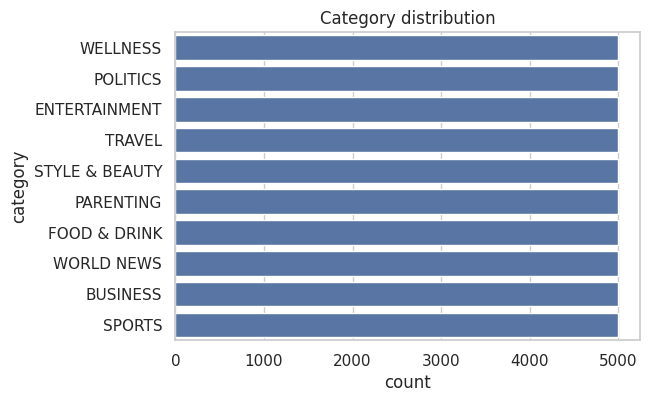

In [29]:
print('Missing texts:', news_df['short_description'].isna().sum())
print('Missing categories:', news_df['category'].isna().sum())

# 🧹 Clean the text column (you can also combine headline + short_description if you want)
news_df['text_clean'] = news_df['short_description'].astype(str).apply(clean_text)

# 📊 Plot the category distribution
plt.figure(figsize=(6,4))
sns.countplot(y=news_df['category'])
plt.title('Category distribution')
plt.show()


In [30]:
label_series = news_df['category'].astype('category')
label_map = dict(enumerate(label_series.cat.categories))
print('label map:', label_map)

y_news = label_series.cat.codes.values
X_news = news_df['text_clean'].values
Xn_train, Xn_test, yn_train, yn_test = train_test_split(X_news, y_news, test_size=0.2, random_state=RANDOM_SEED, stratify=y_news)
print('train/test sizes:', len(Xn_train), len(Xn_test))

label map: {0: 'BUSINESS', 1: 'ENTERTAINMENT', 2: 'FOOD & DRINK', 3: 'PARENTING', 4: 'POLITICS', 5: 'SPORTS', 6: 'STYLE & BEAUTY', 7: 'TRAVEL', 8: 'WELLNESS', 9: 'WORLD NEWS'}
train/test sizes: 40000 10000


In [31]:
tfidf_news = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
Xn_train_tfidf = tfidf_news.fit_transform(Xn_train)
Xn_test_tfidf = tfidf_news.transform(Xn_test)

models_news = {
    'LogisticRegression': LogisticRegression(max_iter=1000, random_state=RANDOM_SEED),
    'NaiveBayes': MultinomialNB(),
    'SVM': LinearSVC(max_iter=5000, random_state=RANDOM_SEED),
    'RandomForest': RandomForestClassifier(n_estimators=200, random_state=RANDOM_SEED)
}

for name, model in models_news.items():
    print('Training', name)
    model.fit(Xn_train_tfidf, yn_train)
    preds = model.predict(Xn_test_tfidf)
    print(name, 'results:')
    print_scores(yn_test, preds, labels=[label_map[i] for i in sorted(label_map.keys())])

Training LogisticRegression
LogisticRegression results:
Accuracy: 0.6840 | Precision: 0.6854 | Recall: 0.6840 | F1: 0.6840

Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.70      0.70      0.70      1000
 ENTERTAINMENT       0.57      0.60      0.59      1000
  FOOD & DRINK       0.68      0.76      0.72      1000
     PARENTING       0.69      0.67      0.68      1000
      POLITICS       0.66      0.59      0.63      1000
        SPORTS       0.75      0.76      0.76      1000
STYLE & BEAUTY       0.74      0.70      0.72      1000
        TRAVEL       0.71      0.67      0.69      1000
      WELLNESS       0.63      0.68      0.65      1000
    WORLD NEWS       0.72      0.70      0.71      1000

      accuracy                           0.68     10000
     macro avg       0.69      0.68      0.68     10000
  weighted avg       0.69      0.68      0.68     10000

Training NaiveBayes
NaiveBayes results:
Accuracy: 0.6714 | Precis

In [32]:
MAX_WORDS_NEWS = 30000
MAX_SEQ_LEN_NEWS = 300
EMBED_DIM_NEWS = 100

tokenizer_news = Tokenizer(num_words=MAX_WORDS_NEWS, oov_token='<OOV>')
tokenizer_news.fit_on_texts(news_df['text_clean'])
Xn_seq = tokenizer_news.texts_to_sequences(news_df['text_clean'])
Xn_pad = pad_sequences(Xn_seq, maxlen=MAX_SEQ_LEN_NEWS, padding='post')

yn_cat = pd.get_dummies(news_df['category']).values
Xn_tr_seq, Xn_te_seq, yn_tr_seq, yn_te_seq = train_test_split(Xn_pad, yn_cat, test_size=0.2, random_state=RANDOM_SEED, stratify=y_news)

model_lstm_news = Sequential([
    Embedding(input_dim=MAX_WORDS_NEWS, output_dim=EMBED_DIM_NEWS, input_length=MAX_SEQ_LEN_NEWS),
    Bidirectional(LSTM(128)),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(yn_cat.shape[1], activation='softmax')
])
model_lstm_news.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm_news.fit(Xn_tr_seq, yn_tr_seq, validation_split=0.1, epochs=5, batch_size=64, callbacks=[EarlyStopping(patience=2)])

preds = np.argmax(model_lstm_news.predict(Xn_te_seq), axis=1)
true = np.argmax(yn_te_seq, axis=1)
print_scores(true, preds, labels=[label_map[i] for i in sorted(label_map.keys())])

Epoch 1/5


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 34ms/step - accuracy: 0.2313 - loss: 2.0351 - val_accuracy: 0.6108 - val_loss: 1.1949
Epoch 2/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 33ms/step - accuracy: 0.6574 - loss: 1.0741 - val_accuracy: 0.6630 - val_loss: 1.0917
Epoch 3/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 18s 32ms/step - accuracy: 0.7914 - loss: 0.6902 - val_accuracy: 0.6570 - val_loss: 1.2259
Epoch 4/5
563/563 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.8593 - loss: 0.4807 - val_accuracy: 0.6557 - val_loss: 1.4282
313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step
Accuracy: 0.6512 | Precision: 0.6537 | Recall: 0.6512 | F1: 0.6491

Classification Report:
                 precision    recall  f1-score   support

      BUSINESS       0.76      0.68      0.72      1000
 ENTERTAINMENT       0.56      0.54      0.55      1000
  FOOD & DRINK       0.68      0.73      0.70      1000
     PARENTING       0.60      0.63      0.61      1000
      POLITICS       0.63      0.56      0.60      1000
        SPORTS       0.7

In [36]:
USE_BERT_NEWS = True
if USE_BERT_NEWS:
    !pip install -U transformers safetensors
    from transformers import TFAutoModel, AutoTokenizer

    BERT_NEWS = 'distilbert-base-uncased'
    news_tokenizer = AutoTokenizer.from_pretrained(BERT_NEWS)
    news_encoder = TFAutoModel.from_pretrained(BERT_NEWS, from_pt=True)

    # ✅ Fix 1: Use the correct text column (combine if needed)
    news_df['text'] = (news_df['headline'].astype(str) + " " + news_df['short_description'].astype(str))

    sample_size = min(len(news_df), 2000)
    Xn_small = news_df['text'].values[:sample_size]
    y_small_cat = pd.get_dummies(news_df['category']).values[:sample_size]

    enc = news_tokenizer(list(Xn_small), truncation=True, padding=True, max_length=128)
    ids = np.array(enc['input_ids'])
    masks = np.array(enc['attention_mask'])

    input_ids_in = Input(shape=(ids.shape[1],), dtype=tf.int32)
    mask_in = Input(shape=(ids.shape[1],), dtype=tf.int32)

    # ✅ Fix 2: Wrap encoder call in a Lambda layer (to make it compatible with Keras Functional API)
    bert_output = Lambda(
        lambda x: news_encoder(input_ids=x[0], attention_mask=x[1]).last_hidden_state,
        output_shape=(128, 768)
    )([input_ids_in, mask_in])

    pooled = GlobalAveragePooling1D()(bert_output)
    x = Dense(128, activation='relu')(pooled)

    # ✅ Fix 3: 'yn_cat' is undefined — should be 'y_small_cat'
    output = Dense(y_small_cat.shape[1], activation='softmax')(x)

    model_news_bert = Model(inputs=[input_ids_in, mask_in], outputs=output)
    model_news_bert.compile(optimizer=tf.keras.optimizers.Adam(2e-5),
                            loss='categorical_crossentropy',
                            metrics=['accuracy'])

    ids_tr, ids_te, masks_tr, masks_te, ytr, yte = train_test_split(
        ids, masks, y_small_cat, test_size=0.2, random_state=RANDOM_SEED
    )

    model_news_bert.fit([ids_tr, masks_tr], ytr, validation_split=0.1, epochs=2, batch_size=16)

    preds_news = np.argmax(model_news_bert.predict([ids_te, masks_te]), axis=1)
    true_news = np.argmax(yte, axis=1)

    # ✅ Optional: Simple label mapping if not defined
    label_map = {i: c for i, c in enumerate(pd.get_dummies(news_df['category']).columns)}

    # ✅ Fix: ensure labels used in report match the actual unique classes
    unique_labels = sorted(list(set(true_news) | set(preds_news)))
    label_names = [label_map[i] for i in unique_labels]

    print_scores(true_news, preds_news, labels=label_names)

else:
    print('News BERT skipped. Set USE_BERT_NEWS=True to run (requires GPU & memory).')


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Epoch 1/2
90/90 ━━━━━━━━━━━━━━━━━━━━ 20s 92ms/step - accuracy: 0.0116 - loss: 2.5727 - val_accuracy: 0.4062 - val_loss: 1.9269
Epoch 2/2
90/90 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - accuracy: 0.7193 - loss: 1.7264 - val_accuracy: 1.0000 - val_loss: 1.1579
13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 343ms/step
Accuracy: 0.9950 | Precision: 0.5000 | Recall: 0.4975 | F1: 0.4987

Classification Report:
                precision    recall  f1-score   support

ENTERTAINMENT       0.00      0.00      0.00         0
     WELLNESS       1.00      0.99      1.00       400

     accuracy                           0.99       400
    macro avg       0.50      0.50      0.50       400
 weighted avg       1.00      0.99      1.00       400

